In [13]:
if Sys.iswindows()
    username = "Alex"
    pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
    using Pkg
    Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")
    using StaticArrays, DifferentialEquations, DynamicalSystems, BenchmarkTools, CairoMakie
    using CairoMakie
        include("C:\\Users\\Alex\\Desktop\\dynamical-systems\\system.jl");
    #include("C:\\Users\\Alex\\Desktop\\dynamical-systems\\visual.jl");
else
    username = "nova"
    pathtorepo = "/home/nova/work/repo_ds/dynamical-systems"
    using Pkg
    Pkg.activate(pathtorepo * "/env/integrate/")
    using StaticArrays, DifferentialEquations, DynamicalSystems
    include("/home/nova/work/repo_ds/dynamical-systems/system.jl")
    #include("/home/nova/work/repo_ds/dynamical-systems/visual.jl")
end

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`


TM6_glial_ECM_help (generic function with 1 method)

In [14]:
tLSE = 1000; tt = 3000; tstep = 0.001;
tol = 1e-15;
integ_set = (alg = Vern9(), adaptive = true, abstol = tol, reltol = tol);

In [15]:
param = TM6_glial_ECM_get_params();
dict, indexparams = TM6_glial_ECM_help(param);
println(indexparams);


    τ - 1, τD - 2, τF - 3, τy - 4, α - 5, αE - 6, αecm - 7, αp - 8,
    J - 9, U0 - 10, I0 - 11, ΔU0 - 12, β - 13, βecm  -14, βp - 15,
    γp - 16, ecm0 - 17, ecm1 - 18, kecm - 19, θecm - 20, p0 - 21, p1 - 22, θp - 23, kp - 24, ythr - 25, xthr - 26


In [16]:
u0 = [0.9445509341100914, 0.74116702856987, 0.7361196042973006, 0.0646914552140727, 0.15145764079879162, 0.0009327645775731449]

6-element Vector{Float64}:
 0.9445509341100914
 0.74116702856987
 0.7361196042973006
 0.0646914552140727
 0.15145764079879162
 0.0009327645775731449

In [17]:
function print_index_param(ds, name_param, index_param)
    println("u0: $(current_state(ds))");
    println("$(name_param): $(current_parameters(ds)[index_param])")
end

function find_zero(Λs; tol = 1e-2)
    vec_bool = Vector{Bool}(undef, 6);
    for (index, lp) in enumerate(Λs)
        checknull=  isapprox(lp, 0.0; atol = tol);
        vec_bool[index] = checknull;
    end
    vec_of_true = findall(x->x==true, vec_bool);
    if length(vec_of_true) >=1
        return 0;
    else
        return -1;
    end;
end

function lyapunovspectrum_adapt(tands, time_lse; tol_ = 1e-2)
    coeff_adapt_time = 1;
    flag = true;
    #tands = TangentDynamicalSystem(ds; J = TM6_glial_ECM_jac);
    Λs = lyapunovspectrum(tands, time_lse);
    while flag == true
        checkzero = find_zero(Λs; tol = tol_);
        if checkzero == -1
            coeff_adapt_time*=2;
            Λs = lyapunovspectrum(tands, time_lse * coeff_adapt_time*10);
        else
            flag = false;
        end
    end
    return Λs, coeff_adapt_time;
end

lyapunovspectrum_adapt (generic function with 1 method)

In [18]:
ds= CoupledODEs(TM6_glial_ECM, u0, param, diffeq = integ_set);
tands = TangentDynamicalSystem(ds; J = TM6_glial_ECM_jac);

systems = [deepcopy(tands) for _ in 1:Threads.nthreads()-1];
pushfirst!(systems, tands);

In [19]:
len = 250;
αE_range = range(0.067, 5.0, length = len);
u0s = zeros(len, 6);
Λs = zeros(len, 6);
Λs_without_parallel = zeros(len, 6);

In [20]:
for index in eachindex(αE_range)

   if index == 1
    global u0loc = u0
   end

   #println("u0:", u0loc); flush(stdout);
   set_state!(ds, u0loc);
   set_parameter!(ds, 6, αE_range[index]);
   #println("αE:", current_parameters(ds)[6]); flush(stdout);
   tr, _ = trajectory(ds, tt);
   
   u0loc = tr[end];
   #println("u0 last:", u0loc); flush(stdout);
   u0s[index, :] = u0loc;
   #println(); flush(stdout);
end

In [21]:
Threads.@threads for i in eachindex(αE_range)
    system = systems[Threads.threadid()]
    set_parameter!(system, 6, αE_range[i])
    set_state!(system, u0s[i, :]);
    Λs[i, :], _ = lyapunovspectrum_adapt(system, tLSE)
end

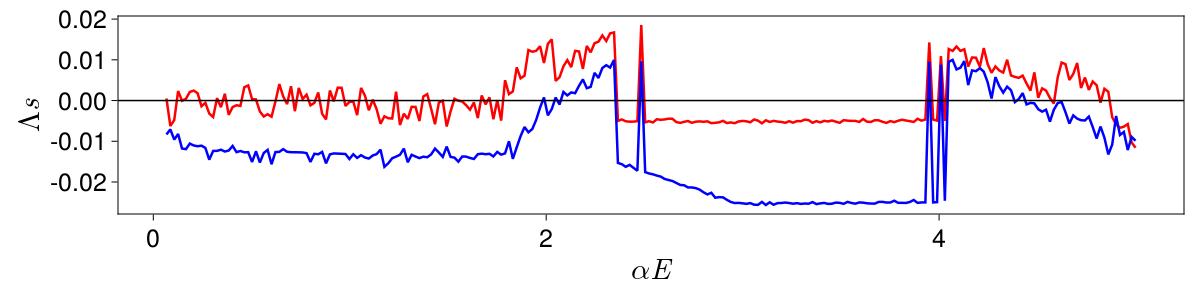

In [25]:
lb_size = 30; tck_size = 25;

f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = L"αE", ylabel = L"\Lambda s",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)

lines!(axis, αE_range, Λs[:, 1], linewidth = 2.5, color = :red)
lines!(axis, αE_range, Λs[:, 2], linewidth = 2.5, color = :blue)
hlines!(axis, 0.0, color = :black, linestyile = :dash)

yticks!
f

In [23]:
for i in eachindex(αE_range)

    set_parameter!(tands, 6, αE_range[i])
    set_state!(tands, u0s[i, :]);
    
    #println("u0:", current_state(tands));; flush(stdout);
    #println("αE:", current_parameters(tands)[6]); flush(stdout);
    #println(); flush(stdout);

    Λs_without_parallel[i, :], _ = lyapunovspectrum_adapt(tands, tLSE)
end

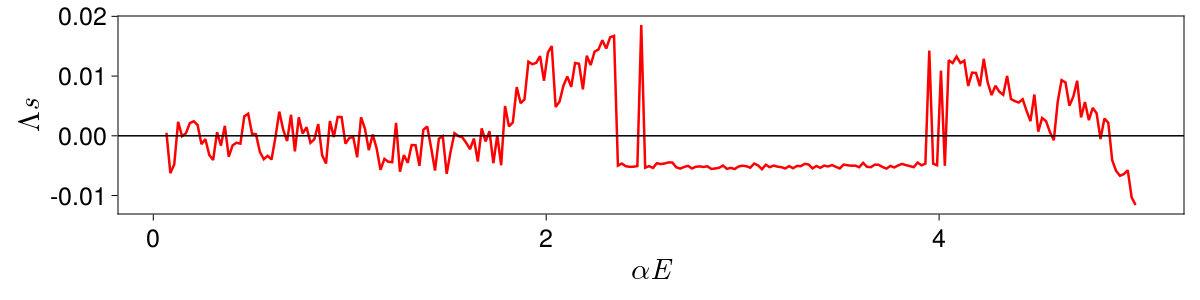

In [139]:
lb_size = 30; tck_size = 25;

    CairoMakie.activate!()
f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = L"αE", ylabel = L"\Lambda s",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)

lines!(axis, αE_range, Λs_without_parallel[:, 1], linewidth = 2.5, color = :red)

hlines!(axis, 0.0, color = :black, linestyile = :dash)

yticks!
f